In [1]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt

In [2]:
earthquake_counts = [
    13, 14, 8, 10, 16, 26, 32, 27, 18, 32, 36, 24, 22, 23, 22, 18, 25, 21, 21, 14,
    8, 11, 14, 23, 18, 17, 19, 20, 22, 19, 13, 26, 13, 14, 22, 24, 21, 22, 26, 21,
    23, 24, 27, 41, 31, 27, 35, 26, 28, 36, 39, 21, 17, 22, 17, 19, 15, 34, 10, 15,
    22, 18, 15, 20, 15, 22, 19, 16, 30, 27, 29, 23, 20, 16, 21, 21, 25, 16, 18, 15,
    18, 14, 10, 15, 8, 15, 6, 11, 8, 7, 18, 16, 13, 12, 13, 20, 15, 16, 12, 18,
    15, 16, 13, 15, 16, 11, 11
]
print("Length of earthquake counts:", len(earthquake_counts))

Length of earthquake counts: 107


In [3]:
year_count=np.array(range(1900,2007))
earthquake_df=pd.DataFrame({
    'year': year_count,
    'earthquake_counts': earthquake_counts
})

In [4]:
earthquake_df.head()

,year,earthquake_counts
0,1900,13
1,1901,14
2,1902,8
3,1903,10
4,1904,16


In [5]:
X = earthquake_df[['earthquake_counts']].values
model = hmm.PoissonHMM(n_components=3, n_iter=100, random_state=42, tol=1e-4)
model.fit(X)
hidden_states = model.predict(X)
print("--- Poisson HMM Analysis Results ---")
print(f"Model converged: {model.monitor_.converged}")
sorted_indices = np.argsort(model.lambdas_.flatten())
sorted_lambdas = model.lambdas_.flatten()[sorted_indices]
sorted_transmat = model.transmat_[sorted_indices, :][:, sorted_indices]
state_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
relabeled_states = np.array([state_map[s] for s in hidden_states])
print(f"\nState 0 (Low-Rate) Mean Earthquakes/Year (λ): {sorted_lambdas[0]:.2f}")
print(f"State 1 (Medium-Rate) Mean Earthquakes/Year (λ): {sorted_lambdas[1]:.2f}")
print(f"State 2 (High-Rate) Mean Earthquakes/Year (λ): {sorted_lambdas[2]:.2f}")
print("\nTransition Matrix:")
print(pd.DataFrame(sorted_transmat, 
                   columns=["To Low", "To Medium", "To High"], 
                   index=["From Low", "From Medium", "From High"]))

--- Poisson HMM Analysis Results ---
Model converged: True

State 0 (Low-Rate) Mean Earthquakes/Year (λ): 14.69
State 1 (Medium-Rate) Mean Earthquakes/Year (λ): 23.82
State 2 (High-Rate) Mean Earthquakes/Year (λ): 25.24

Transition Matrix:
                   To Low     To Medium       To High
From Low     9.345545e-01  6.522624e-02  2.192140e-04
From Medium  1.734853e-10  2.918238e-15  1.000000e+00
From High    1.419131e-01  8.580869e-01  1.782182e-15


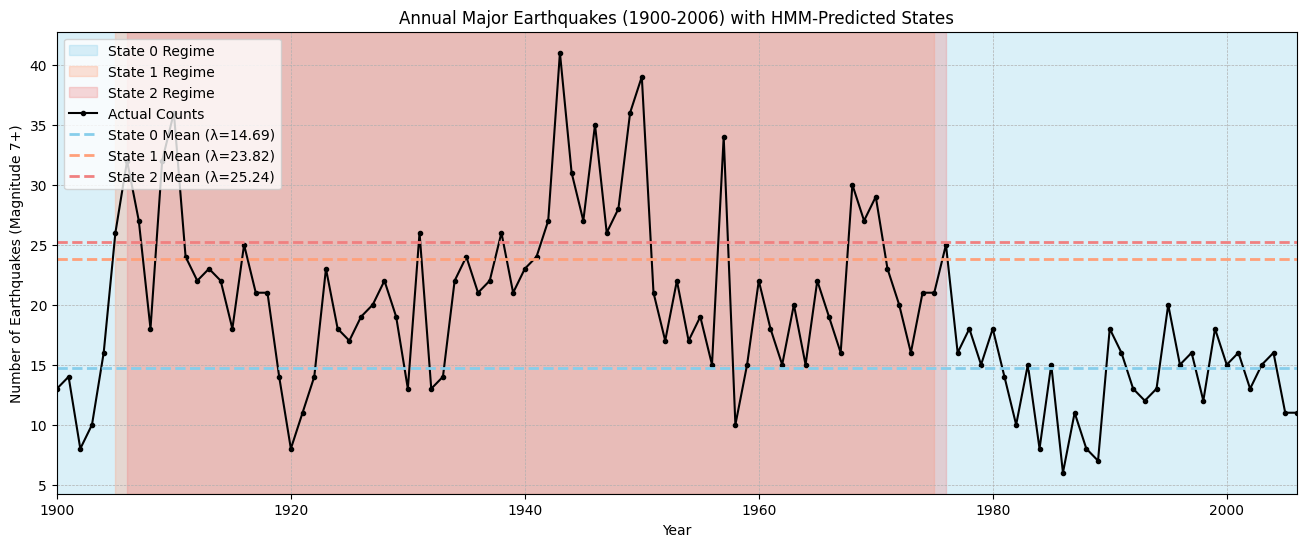

In [6]:
# 5. Visualize the results
fig, ax = plt.subplots(figsize=(16, 6))

# Use axvspan to color the background according to the hidden state
colors = ['#87CEEB', '#FFA07A', '#F08080'] # SkyBlue, LightSalmon, LightCoral
for i, state_idx in enumerate(sorted_indices):
    mask = (relabeled_states == i)
    ax.axvspan(earthquake_df['year'][mask].min(), earthquake_df['year'][mask].max(), 
               color=colors[i], alpha=0.3, label=f'State {i} Regime')

# Plot the actual earthquake counts
ax.plot(earthquake_df['year'], earthquake_df['earthquake_counts'], '-o', label='Actual Counts', color='black', markersize=3)

# Plot the learned means (lambdas) as horizontal lines
for i, lam in enumerate(sorted_lambdas):
    ax.axhline(y=lam, color=colors[i], linestyle='--', lw=2, 
               label=f'State {i} Mean (λ={lam:.2f})')

# Formatting
ax.set_title('Annual Major Earthquakes (1900-2006) with HMM-Predicted States')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Earthquakes (Magnitude 7+)')
ax.legend(loc='upper left')
ax.grid(True, which='major', linestyle='--', linewidth=0.5)
ax.set_xlim(earthquake_df['year'].min(), earthquake_df['year'].max())

plt.show()

In [7]:
model_2_state = hmm.PoissonHMM(n_components=2, n_iter=100, random_state=42, tol=1e-4)
model_2_state.fit(X)
model_3_state = hmm.PoissonHMM(n_components=3, n_iter=100, random_state=42, tol=1e-4)
model_3_state.fit(X)

print("Both models have been trained.")

Both models have been trained.


In [8]:
def calculate_aic_bic(model, data):
    """Calculates AIC and BIC for a trained stationary PoissonHMM."""
    m = model.n_components
    n_params = m**2 # For a stationary Poisson HMM
    
    log_likelihood = model.score(data)
    n_samples = len(data)
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = n_params * np.log(n_samples) - 2 * log_likelihood
    
    return {
        'Log-Likelihood': log_likelihood,
        '# Parameters': n_params,
        'AIC': aic,
        'BIC': bic
    }
scores_2_state = calculate_aic_bic(model_2_state, X)
scores_3_state = calculate_aic_bic(model_3_state, X)
comparison_df = pd.DataFrame([scores_2_state, scores_3_state], index=['2-State HMM', '3-State HMM'])
print("\n--- Model Comparison ---")
print(comparison_df.round(2))


--- Model Comparison ---
             Log-Likelihood  # Parameters     AIC     BIC
2-State HMM         -341.88             4  691.76  702.45
3-State HMM         -342.16             9  702.32  726.37


/home/raghav-iyengar/smac/venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


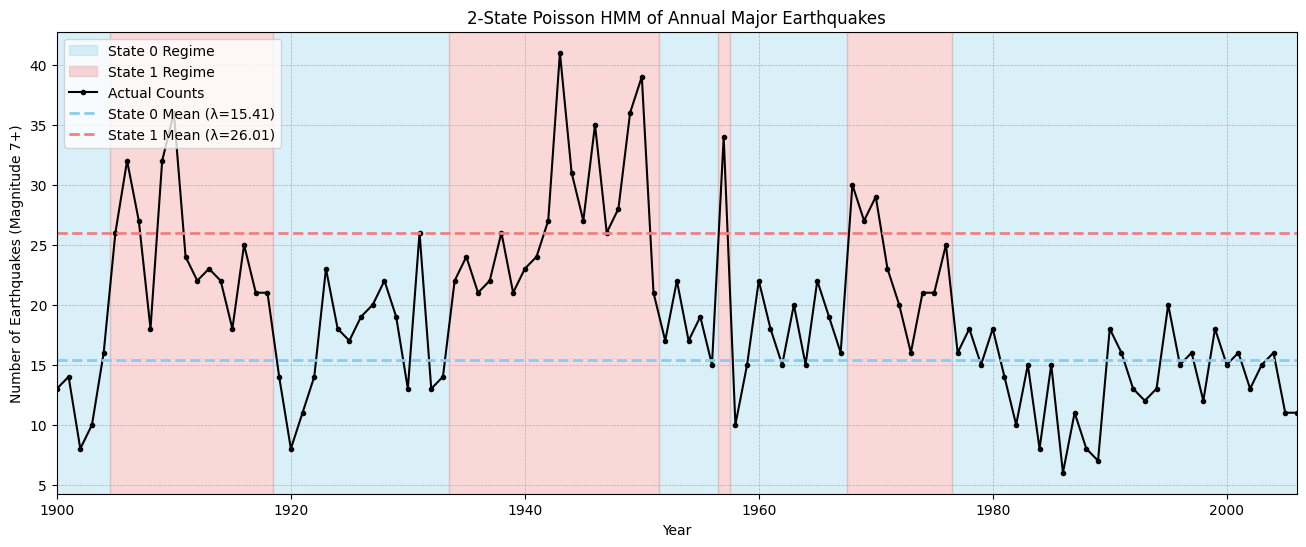

In [9]:
hidden_states_2 = model_2_state.predict(X)
sorted_indices_2 = np.argsort(model_2_state.lambdas_.flatten())
sorted_lambdas_2 = model_2_state.lambdas_.flatten()[sorted_indices_2]
state_map_2 = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices_2)}
relabeled_states_2 = np.array([state_map_2[s] for s in hidden_states_2])

fig, ax1 = plt.subplots(figsize=(16, 6))
colors_2 = ['#87CEEB', '#F08080']  # SkyBlue, LightCoral
ax1.set_title('2-State Poisson HMM of Annual Major Earthquakes')

for i, state_idx in enumerate(sorted_indices_2):
    mask = (relabeled_states_2 == i)
    # Use a dummy plot for the legend label
    ax1.axvspan(0, 0, color=colors_2[i], alpha=0.3, label=f'State {i} Regime')
    # Fill the background for all periods in this state
    for year_block in np.split(earthquake_df['year'][mask], np.where(np.diff(earthquake_df['year'][mask]) != 1)[0] + 1):
        if len(year_block) > 0:
            ax1.axvspan(year_block.min() - 0.5, year_block.max() + 0.5, color=colors_2[i], alpha=0.3)

ax1.plot(earthquake_df['year'], earthquake_df['earthquake_counts'], '-o', label='Actual Counts', color='black', markersize=3)
for i, lam in enumerate(sorted_lambdas_2):
    ax1.axhline(y=lam, color=colors_2[i], linestyle='--', lw=2, label=f'State {i} Mean (λ={lam:.2f})')

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Earthquakes (Magnitude 7+)')
ax1.legend(loc='upper left')
ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
ax1.set_xlim(earthquake_df['year'].min(), earthquake_df['year'].max())

plt.show()